<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/QiskitVQC_FLMNISTOptimizerChange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output



Initial source - https://www.qmunity.tech/tutorials/building-a-variational-quantum-classifier

Build a quantum machine learning algorithm that classifies and recognizes handwritten digits(whether a digit is 0 or 1) present in the MNIST dataset. We will make use of several dimensional reduction techniques, perform classical pre-processing and initialize our own quantum feature maps.

In [3]:
#Install required Dependencies
!pip install --upgrade seaborn
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install --upgrade pandas
!pip install --upgrade qiskit
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
import numpy as np
from qiskit.utils import algorithm_globals
!pip install qiskit_machine_learning

import time

clear_output()

In [17]:

from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit.utils import algorithm_globals
import numpy as np
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer
from qiskit import BasicAer, execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA

#from DUNWeightingFramework import *
#This is to get client weights which get by classical learning - preprocess.

# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()


┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐ ░ »
«   q_0: ┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├┤ Rz(θ[10]) ├─░─»
«        ├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤├───────────┤ ░ »
«   q_1: ┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─»
«        └──────────┘   └──────────┘└──────────┘   └──────────┘└───────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌─┐   
«   q_0: ┤M├───
«        └╥┘┌─┐
«   q_1: ─╫─┤M├
«         ║ └╥┘
«meas: 2/═╩══╩═
«         0  1

## **STEP 01: Loading Data and Preprocessing pipeline**

In [7]:
image_size = 28 # width and length are equal
data_path= "/content/drive/MyDrive/Colab Notebooks/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

ADDITIONAL STEP : DUN TRAIN

--STRUCTURE OF THE TRAINING DATA--

The MNIST dataset has a total of  60,000 data points (rows in train_data) corresponding to digits ranging from 0 to 9
The first column has the label of the datapoint ranging from 0 to 9
The next 784 columns/features are each a 28x28 pixel grayscale image collapsed into a row. The dimension of the dataset is 784. Each of these values range from 0 to 255 where 0 corresponds to white and 255 corresponds to black and any value between 0 and 255 corresponds to a color which is a mix of black and white.
The testing dataset has the same form except it has 10000 data points. In order to get an idea of a picture of a digit inside the dataset, we will run the following code.

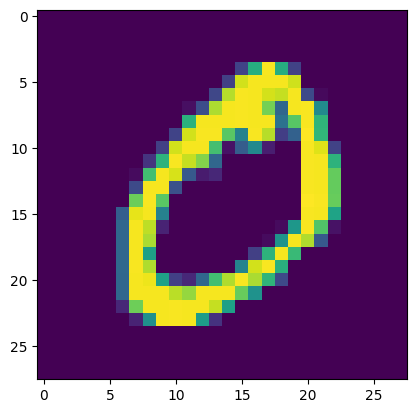

In [8]:
img = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(img)
plt.show()

--APPLY DIMENSIONALITY REDUCTION----

The dimension of the data corresponds to the number of qubits required in order to encode the data for the quantum feature maps we will later initialize. Since quantum computers today can only manipulate 50 qubits, we cannot work with large number of qubits like 784, therefore encoding data with dimension 784 is not viable.

Therefore, we will have to make use of the truncated Singular Value Decomposition (SVD) and t-distributed stochastic neighbor embedding (t-SNE) methods to reduce the dimension down to 10 and then to 2

784->10->2 ->require 2 quibits

In [9]:
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

We will plot out the dataset to see if there is some sort of clustering due to classification of digits in the reduced dataset

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


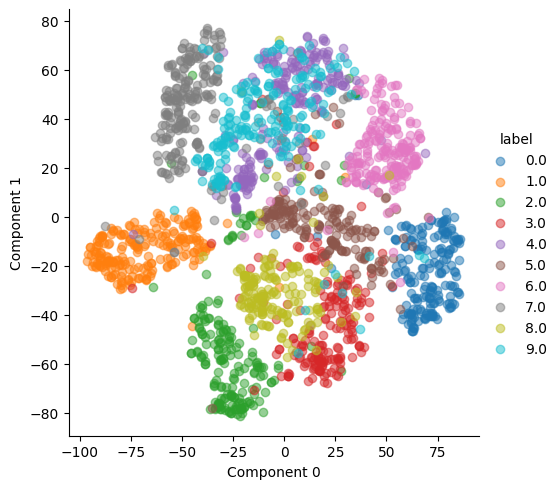

In [10]:
# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

--OBSERVATIONS--
0 and 1 are well separated on opposite corners as they are easily distinguishable, however, 4 and 9 are overlapping as corresponding to purple and blue data points.

## STEP 02 - EXTRACTING AND NORMALIZING DATA ***

We will extract data points corresponding to the digits 0 and 1 from the reduced dataset and normalize their features to be between 0 and 2.
We need to normalize the data because the values will be inserted into a quantum feature map

In [11]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])

zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n
zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

## **STEP 03- VARIATIONAL QUANTUM CLASSFIER DEFINE**

VQC has a training stage (where data points with labels are provided and learning takes place) and a testing stage (where new data points without labels are provided which are then classified)

Tha main steps of this algorithm

1. Load Data onto the Quantum Computer by Applying a Quantum Feature Map Φ(x).
2. Build and apply short-depth Variational Circuit W(θ).
(In here depth means nub=mber of iterations for parameterixed unitaries here. it is also improve expressabilitiy because of increasing parameters with the number of reapeted times.-REsource  Amira's talk -https://www.youtube.com/watch?v=-sxlXNz7ZxU
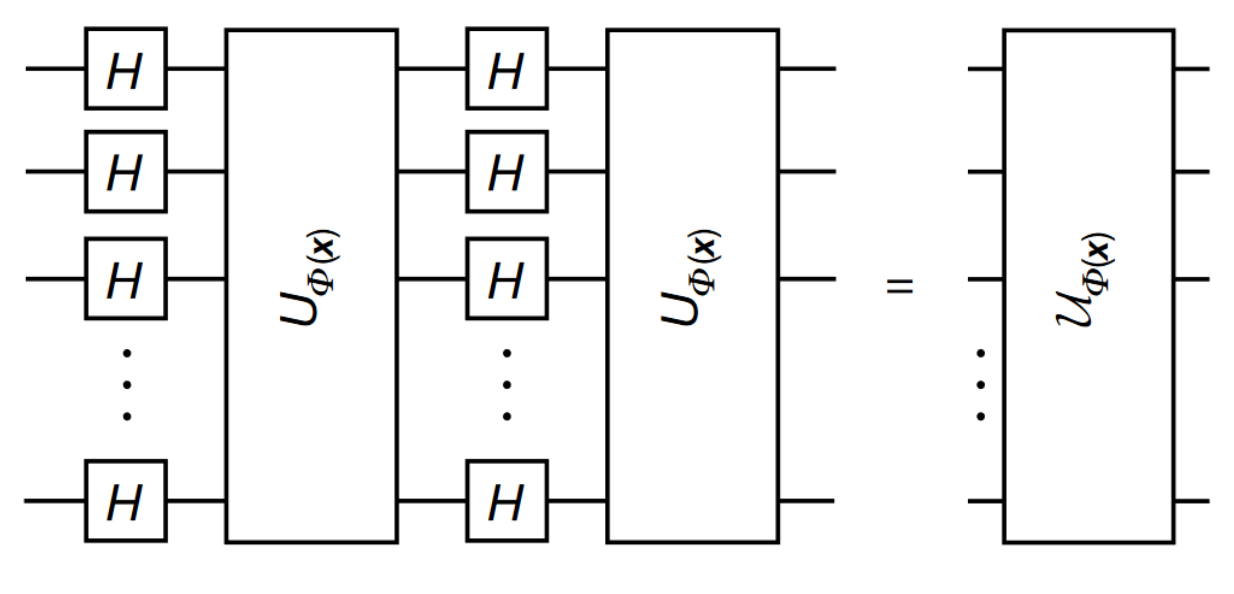


STEP 04- BUILDING FEATURE MAP-A feature map is a variational circuit.

Some of the feature maps include:

ZFeatureMap
ZZFeatureMap
PauliFeatureMap

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
pauli_feature_map.draw()

┌─────────────────────────────┐
q_0: ┤0                            ├
     │  PauliFeatureMap(x[0],x[1]) │
q_1: ┤1                            ├
     └─────────────────────────────┘

We also want that the corresponding quantum feature map circuit is shallow( have a small circuit depth) as this reduces quantum decoherence, leading to higher accuracies.

we want to construct custom feature maps for increasing the accuracy of classification.

STEP 05- APPEND FEATURE MAPS TO VARIATIONAL CIRCUIT>

use classical optimizers in training stage.

In [ ]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
#instead we can also use var_circuit = EfficientSU2(feature_dim, reps=2)

Custom feature map for optional use--
steps

Create a ParameterVector object which stores the list of Parameters
Create QuantumCircuit object
Iterative over the number of qubits and add the gates.

But this is not using in this impelementaions

In [ ]:
'''
from qiskit.circuit import QuantumCircuit, ParameterVector
num_qubits = 3
iter = 1              # number of times you'd want to repeat the circuit

x = ParameterVector('x', length=num_qubits)  # creating a list of Parameters
custom_circ = QuantumCircuit(num_qubits)

# defining our parametric form
for _ in range(iter):
    for i in range(num_qubits):
        custom_circ.rx(x[i], i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u1(x[i] * x[j], j)
            custom_circ.cx(i, j)

custom_circ.draw()
'''

#Classification Done

We will take a very small subset of 20 training datapoints and 10 testing datapoints. We also keep 5 points per label as a validation set. We will first define the training and testing inputs based on the dataset we initialized before.

In [ ]:
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A':zero_train, 'B':one_train}
test_input = {'A':zero_test, 'B':one_test}

# datapoints is our validation set
datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

In [12]:
import numpy as np

# Assuming you have the data defined as per your initial code
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A': zero_train, 'B': one_train}
test_input = {'A': zero_test, 'B': one_test}

datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

# Split data for 5 clients
num_clients = 5
client_data = {f'Client_{i+1}': {'TRAIN_DATA': [], 'TRAIN_LABELS': [], 'TEST_DATA': [], 'TEST_LABELS': []} for i in range(num_clients)}

for i in range(num_clients):
    start_idx = i * (train_size // num_clients)
    end_idx = (i + 1) * (train_size // num_clients)

    client_data[f'Client_{i+1}']['TRAIN_DATA'] = np.concatenate((zero_train[start_idx:end_idx], one_train[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TRAIN_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

    start_idx = i * (test_size // num_clients)
    end_idx = (i + 1) * (test_size // num_clients)

    client_data[f'Client_{i+1}']['TEST_DATA'] = np.concatenate((zero_test[start_idx:end_idx], one_test[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TEST_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

# Print client data
for client, data in client_data.items():
    print(f'{client}:')
    print(data)
    print()


Client_1:
{'TRAIN_DATA': array([[1.7128973 , 0.69763577],
       [1.7548386 , 0.6635097 ],
       [1.5829053 , 0.6011364 ],
       [1.6286227 , 0.60453415],
       [0.09574234, 0.7985937 ],
       [0.61329985, 0.8613864 ],
       [0.5728667 , 0.9636276 ],
       [0.5144396 , 0.9647155 ]], dtype=float32), 'TRAIN_LABELS': array([0, 0, 0, 0, 1, 1, 1, 1]), 'TEST_DATA': array([[1.8032928 , 0.85159564],
       [1.824754  , 0.90558416],
       [1.1363562 , 1.3150004 ],
       [0.3814525 , 0.93074846]], dtype=float32), 'TEST_LABELS': array([0, 0, 1, 1])}

Client_2:
{'TRAIN_DATA': array([[1.7857454 , 0.7875675 ],
       [1.853204  , 0.824271  ],
       [1.7540939 , 0.67810833],
       [1.7745657 , 0.98342216],
       [0.0910604 , 0.80118203],
       [1.2950903 , 1.1609468 ],
       [0.44092774, 0.8916762 ],
       [0.13289344, 0.8107393 ]], dtype=float32), 'TRAIN_LABELS': array([0, 0, 0, 0, 1, 1, 1, 1]), 'TEST_DATA': array([[1.5976703 , 0.9176028 ],
       [1.5922863 , 0.9626111 ],
       [0.41

Train Labels Data Type: <class 'str'>
Test Labels Data Type: <class 'str'>
Train Labels: TRAIN_LABELS
Test Labels: TEST_LABELS


In [13]:
# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

class localOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

initial_point = np.random.random(VAR_FORM.num_parameters)

In [14]:
#Global optimizer log
class GlobalOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

global_optimizer_log = GlobalOptimizerLog()

# Initialize global model
global_model = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(callback=global_optimizer_log.update),
    initial_point=initial_point,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

<ipython-input-14-d794646cea55>:18: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  global_model = VQC(


In [15]:
import warnings
# Training settings
num_rounds = 2
learning_rate = 0.01  # Adjust as needed

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []
global_parameters=[]
global_cost=[]

# Array to store global cost
GlobalCostperRoundAll=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]
    aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
    # Train each client's data on their VQC models
    for client_id, data in client_data.items():
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress warnings
        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        client_parameters.append(Locallog.parameters[-1])
        cost = Locallog.costs[-1]
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")

print("Local training done")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
        # Append the client's updated parameters
        #aggregated_params += client_parameters
        # Store client's updated parameters

        # Print the cost for each client in each round
         # Aggregation step
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
aggregated_params = np.mean(client_parameters, axis=0)  # Calculate mean of parameters

# Update global parameters for the next round
global_parameters = aggregated_params
     # Aggregate client parameters
print(f"Round {round_num},global: aggregated_gradients = {global_parameters}")

     # Update the global optimizer log with the aggregated parameters
global_optimizer_log.parameters.append(global_parameters)
global_model.fit(train_data, train_labels)
global_cost = global_optimizer_log.costs
print(f"Round {round_num},global cost: {global_cost}")

Run This code instead above two

In [45]:
from qiskit.algorithms.optimizers import SLSQP
#Local Training with Global Training
import warnings
warnings.filterwarnings("ignore")
# Training settings
num_rounds = 2
learning_rate = 0.001  # Adjust as needed

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []
global_parameters=[]
global_cost=[]

# Array to store global cost
GlobalCostperRoundAll=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]
    aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
    # Train each client's data on their VQC models
    for client_id, data in client_data.items():
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress warnings
        Locallog = localOptimizerLog()
        optimizer = SLSQP(maxiter=500, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        client_parameters.append(Locallog.parameters[-1])
        cost = Locallog.costs[-1]
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")


    #aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
    aggregated_params = np.mean(client_parameters, axis=0)  # Calculate mean of parameters

    # Update global parameters for the next round
    global_parameters = aggregated_params
    # Aggregate client parameters
    print(f"Round {round_num},global: aggregated_gradients = {global_parameters}")

    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num},global cost: {global_cost}")

print("Federated training done")

TypeError: ignored

In [ ]:
#each client cost variations over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs, label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution for Optimization-Mnist Data')
plt.legend()
plt.show()

In [ ]:
len(global_optimizer_log.costs[-100:])

100

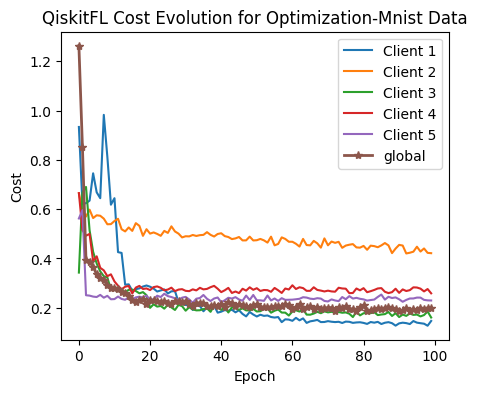

In [32]:
#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs[-100:], label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution for Optimization-Mnist Data')
plt.legend()
plt.show()

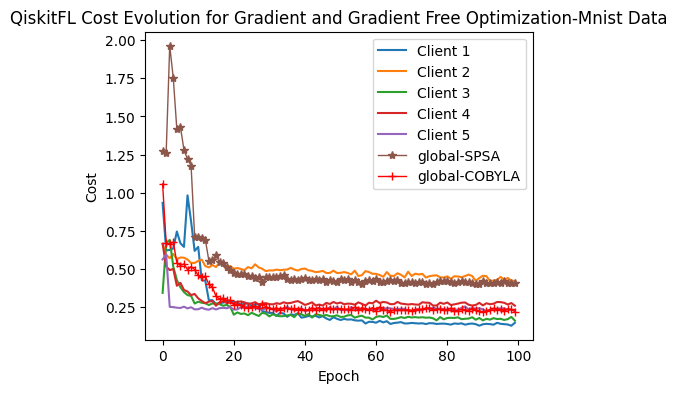

In [36]:
Cost1=[]
Cost2=[]
Cost1=[1.9277141357498593, 0.7629990754661624, 0.8169662944565909, 0.7907686930699371, 0.7737140081026022, 0.756247629221168, 0.6656468085563045, 0.6707604118699754, 0.5984370994142627, 0.5998791874340065, 0.606979132582834, 0.5919738057970613, 0.5126768783706519, 0.5072867854692285, 0.5360987226713447, 0.4528769224653668, 0.4550272697508393, 0.4422698956101969, 0.43813170234142296, 0.4365150639594434, 0.438813269227306, 0.4145299676816827, 0.4079830558666523, 0.4125132771823671, 0.40521067678088063, 0.38576819998608336, 0.40708509772384216, 0.39653783394973885, 0.3999247244819657, 0.40111140403612844, 0.384027757833044, 0.3827656405233385, 0.3706476938797114, 0.39407669415971536, 0.39884414283043124, 0.36702790131521834, 0.35223614012609883, 0.35643674555835975, 0.35196651355451286, 0.3701298623954787, 0.34494134809897314, 0.3588096406497516, 0.3413535375299423, 0.3474256068683954, 0.3495664819296012, 0.35406603345889087, 0.3540994617075503, 0.34287673574977895, 0.35080444448265846, 0.34758804925317177, 0.3522010412862309, 0.3510586435839409, 0.3455801981902792, 0.34101825744755554, 0.3271054645165835, 0.3319413723932435, 0.34466959645504003, 0.32791987075014534, 0.3394960687120204, 0.3110733386180238, 0.33464610443543974, 0.3351263735449381, 0.3367623392651142, 0.3375904889219521, 0.3191525018532677, 0.3215242942735044, 0.32960264219095736, 0.3205283245779374, 0.32555884733823276, 0.31531053954857224, 0.33905763258072724, 0.33198467489461775, 0.31810393162975503, 0.32837538935014504, 0.30794013002927473, 0.33764973679954635, 0.3180443602436666, 0.3256024259854672, 0.32614434219585103, 0.3440637283842657, 0.3170361194821193, 0.3182250282049356, 0.31731438498468983, 0.3223679952534215, 0.30277765255588446, 0.30288620905684255, 0.3199825696705933, 0.3108597720850145, 0.3265776982120189, 0.3282868126764898, 0.3130115888986506, 0.3158141063862645, 0.31525068646182736, 0.30901275922575544, 0.3045282504477057, 0.30838055393336655, 0.3155395383546087, 0.31231893902297536, 0.30819392586602057, 0.29401706585912135, 0.9966776095043971, 0.5725362338862902, 0.611920202806287, 0.5914807420269178, 0.5128066026074206, 0.48545671101185206, 0.4835733598836486, 0.4698416746639638, 0.4682567519873885, 0.4682267084250056, 0.44390711399260396, 0.4369065060178648, 0.42588352414369535, 0.413628975278878, 0.37256662101771526, 0.29654544354364654, 0.31587947421290274, 0.3032372887553446, 0.29653349258011985, 0.262565945130747, 0.27419879135560893, 0.2541768655634656, 0.258929047993005, 0.24440065097691666, 0.24798548154450162, 0.23993285165559564, 0.2488136250959166, 0.25251721028571406, 0.24950706936823838, 0.26238840920633766, 0.24534962848201353, 0.24385123739418846, 0.2311274431407342, 0.24305548386517128, 0.23755574305447216, 0.23724456645092296, 0.2382481632164832, 0.23584652776743106, 0.24065064845635364, 0.23204246928792457, 0.23742459632246932, 0.22576807032081952, 0.23187832624601612, 0.24137024934119936, 0.23761442967179489, 0.2390512150689708, 0.22907161498855821, 0.23751835082885625, 0.23520000909228705, 0.23475040310943157, 0.23722140602987601, 0.23882405986526792, 0.23524630843772706, 0.23303415878975586, 0.23343804254896602, 0.24723942741893837, 0.2244622149997979, 0.24003687290761022, 0.23219562197716623, 0.2302052501032965, 0.24035516114810662, 0.220356172901196, 0.2444320393022955, 0.22539593368502137, 0.2281153794659789, 0.22004466888225813, 0.22585776514045489, 0.23078040383183124, 0.2239063552736732, 0.22011748557108618, 0.22781240907636136, 0.2199832732518162, 0.225345871214605, 0.22805846366698246, 0.22553486579234772, 0.23446136708951498, 0.2420204796484981, 0.22648777855098, 0.2234635493651404, 0.2355797487468769, 0.22454618900903067, 0.2300652812832701, 0.23606180428547435, 0.223009993152123, 0.22216924189465653, 0.22903139769073852, 0.22931076144401116, 0.2241477511133793, 0.2315502962789052, 0.22458768266858797, 0.21589635989861294, 0.2180580689686093, 0.2223533564846009, 0.22947068481799365, 0.23549572788523043, 0.22715463514342427, 0.2304422868136722, 0.22049905127134992, 0.2312810002650936, 0.22274132606086378, 1.3570397975938326, 1.4607171480567955, 1.3032659571820784, 1.1802286132762594, 0.9062206847742551, 0.673625560226702, 0.6643432742852603, 0.5101005510091928, 0.46160926420208526, 0.4769623522619643, 0.28180808924526934, 0.2554542866017267, 0.2587944242418959, 0.23922631756816226, 0.2481688614858599, 0.2532544222336822, 0.24077834990402971, 0.2381510409119174, 0.23584242332784872, 0.2501246367676331, 0.23822471748126095, 0.23702043052486016, 0.2597807176488891, 0.23738747424771864, 0.2381044006317533, 0.231264846438375, 0.2544951701463062, 0.2315230861233168, 0.24712044651851722, 0.24053707020916043, 0.23990599070654012, 0.23891303922209423, 0.23461767209934914, 0.24492417783508239, 0.2451589428283314, 0.2413953484252591, 0.23751603273455163, 0.23743521913843765, 0.2409230295766595, 0.24009081440274543, 0.23634283203238587, 0.22938161103860233, 0.23025156392448265, 0.24359841240509897, 0.2320846093928742, 0.2571572630110738, 0.24232560980046794, 0.23526076853482022, 0.2320302635517072, 0.23889501577201944, 0.23288292472317765, 0.22880368479034197, 0.23186836256686083, 0.2514225266899833, 0.24229641226628235, 0.23683999880770631, 0.23149190269602576, 0.22699520202276466, 0.25034933126658737, 0.24520878820355768, 0.24527929025322287, 0.23767030083083032, 0.22104621767550825, 0.24100871897843623, 0.230586822352051, 0.2338866493934023, 0.24188809523453944, 0.23761106840689966, 0.24660658936154498, 0.23822984403135697, 0.23758851965914285, 0.2532995104600926, 0.2545172525221688, 0.22384987794314415, 0.23669522221026212, 0.24063920418385587, 0.23844726335282665, 0.24805937993235647, 0.24442719828806622, 0.24055104244242714, 0.24045531554401334, 0.2282075999244586, 0.23818698467511767, 0.2278144156289763, 0.24552902463102763, 0.23513249364236596, 0.2416532001482104, 0.2405507472395293, 0.23161247453077724, 0.23370707339699162, 0.23951822461987332, 0.24061514647626717, 0.22724821934199835, 0.24545611319378388, 0.23515022892094783, 0.23795064229104507, 0.24600600224220426, 0.25365373902514066, 0.23122335363446583, 0.24795346714497232, 1.2712964666476279, 1.2620839764961658, 1.9641682904799729, 1.7512051601128662, 1.4151122424617042, 1.4317248134689384, 1.2812978339765264, 1.2190438377645298, 1.1783007255516404, 0.7116361846052147, 0.7087043181166252, 0.7000278277383492, 0.6926257188821587, 0.5532909278659061, 0.5581277203956247, 0.5883218654553959, 0.5434360117962386, 0.5398352858807585, 0.5154555114393741, 0.49403092115915026, 0.4755184064866517, 0.46616498358661806, 0.46910336803202646, 0.4654980423540307, 0.4558334607350184, 0.4525926221762239, 0.4415026657496212, 0.4468585400429889, 0.41466868775189314, 0.44813928722069973, 0.4464950084042318, 0.4487248006729728, 0.44442533009277707, 0.4537619519747422, 0.46115086850429055, 0.4358761262798026, 0.4242651425922163, 0.43166963438092926, 0.42452207671740894, 0.4351432283749863, 0.4386895579877861, 0.42615602717143075, 0.427170707511328, 0.4331220366236609, 0.426404766445314, 0.43375434783526673, 0.4163527300518289, 0.42464859646005326, 0.4191800921762294, 0.4111795923066455, 0.4350179800622287, 0.42531930373461346, 0.4339819896338415, 0.41252118596009135, 0.4249476016460868, 0.4113321981126145, 0.402351208586725, 0.4216619442003994, 0.4247911083611926, 0.41858640440479544, 0.4309134188412886, 0.4155992977088582, 0.4111087793442342, 0.42083373711119315, 0.42993302252337584, 0.41892079697566376, 0.4283626279503232, 0.4093253614271378, 0.4095965300407034, 0.41077975187357474, 0.4123091707364678, 0.40839289368523496, 0.414341819397302, 0.4114507998903837, 0.39788750936645656, 0.40844366003091576, 0.4024417070017674, 0.4115492774949474, 0.4235756316285162, 0.4181649211401851, 0.42122263611022936, 0.4131995742807713, 0.4093235024378653, 0.41426834919433253, 0.4228707886347972, 0.41483210750917043, 0.41471437506605746, 0.41069086802846494, 0.40415834672097345, 0.39794950154122083, 0.41881446910736186, 0.41058557625004155, 0.4072112507337041, 0.4072620241774499, 0.4147780269519921, 0.4079462620715736, 0.42247546148246795, 0.4103355174174714, 0.41069986506105294, 0.41023739729030606]
Cost2=[1.648285010600976, 1.5708314558785477, 1.659635878076108, 1.3944507282843388, 1.1266803946821122, 1.0073610475817825, 0.8532811238708521, 0.7162123461890775, 0.6335315461377178, 0.6330313007456125, 0.5866841587590134, 0.44065183481581716, 0.46661107662426393, 0.4558531629485878, 0.43734310235041424, 0.4096416074347007, 0.4314014138073819, 0.40231182817628225, 0.4174276989510598, 0.40038781235614973, 0.37847444708208167, 0.3847618734748538, 0.384955224775711, 0.3663253919276036, 0.36407578700678855, 0.3796712457377799, 0.36552980175818667, 0.36258784128375565, 0.3647013404246295, 0.3488476253463132, 0.3470583751260149, 0.35357226306412237, 0.36633153619338804, 0.35756981397268234, 0.3329429804453796, 0.3644008807562378, 0.35247035924232967, 0.34391995475395976, 0.3414939051212604, 0.34019351715368085, 0.35179811060431415, 0.3293548583510319, 0.32628508868829553, 0.32930085255614217, 0.3408333288166592, 0.3323672310171202, 0.33630238228970216, 0.3331169556648945, 0.33953945544031905, 0.3379903620485834, 0.34861177080650335, 0.32853765588035916, 0.33878463754298016, 0.3385585693524212, 0.3300575498994937, 0.33926485024718434, 0.33551185613153134, 0.3354489419792423, 0.32884152941988826, 0.33782712298087775, 0.346282679688629, 0.3314859488667034, 0.33249572943390027, 0.3272370004969353, 0.3351370847506414, 0.3284894404903827, 0.33226807884851084, 0.3224338632701242, 0.3296149629757809, 0.3331720740343804, 0.32992476428380074, 0.32975366718938653, 0.357458960983826, 0.33646937248092235, 0.356145839719023, 0.34098908614101886, 0.3330140417024534, 0.3378715114333818, 0.3133873168406782, 0.3383665716034445, 0.34064548886985996, 0.3360844819085619, 0.3352042987402597, 0.31459636136337754, 0.3235525101477418, 0.34169403570574663, 0.3258967908101141, 0.336887163662431, 0.3441979509738307, 0.33388258266815696, 0.3280083422697688, 0.3376415176660774, 0.33822291794342374, 0.3266378410987347, 0.32848364613785086, 0.3424409343638488, 0.32855719470005124, 0.3282522517733289, 0.33458538909340557, 0.34829267335561465, 1.057598977587605, 0.6687902661203882, 0.6608018790197995, 0.67669782905248, 0.5399464991414933, 0.5220740016746521, 0.5326183161143745, 0.4959519900408476, 0.5143652357738352, 0.49566132429626697, 0.45685007433425096, 0.44685634921271744, 0.45184485698304616, 0.39802569616811145, 0.380320961280728, 0.3199092933185732, 0.30319351214450596, 0.30872814964715384, 0.29279550147286193, 0.2947082507020461, 0.26393690254043123, 0.2690251646516346, 0.26054312571388627, 0.24830089300831043, 0.2402459169393146, 0.25275568297582235, 0.2558537057302921, 0.24652737123651583, 0.2689655910187178, 0.25167652618400704, 0.24122341018406868, 0.2357129596884856, 0.2447898211365757, 0.2320313854216815, 0.24253975506019992, 0.24133363236167546, 0.2380604578646066, 0.24066442092824214, 0.23327038409023074, 0.23829333133772612, 0.23017544439277532, 0.2322165283580775, 0.24317852123128375, 0.2331548473419109, 0.24455206556151166, 0.2285354756739531, 0.24299776783987803, 0.23691217145226842, 0.24018485839400605, 0.23733192046613147, 0.2401670410067801, 0.23571483564570672, 0.23591936263721902, 0.23116015724363378, 0.2495437268282425, 0.2313311801194845, 0.2455904525843456, 0.2377049904206961, 0.23287045547456842, 0.24550691990640122, 0.22485699749910532, 0.25056469567414297, 0.2299556869189462, 0.23022878584592227, 0.21796638111746447, 0.23002648621785982, 0.22915313932572856, 0.23063530273797, 0.23065689909864256, 0.23174414328964082, 0.2262974240817852, 0.23341411807273302, 0.23749975713451038, 0.23377434231974703, 0.24067511300074876, 0.24506008348812705, 0.2293322555862191, 0.23545509325733635, 0.23538351899761503, 0.23317656272803436, 0.23253828424743825, 0.2426915133653735, 0.22382736616776766, 0.22664211947101776, 0.2343260287215921, 0.23062286560136053, 0.22520302679455673, 0.23900972428147044, 0.23355413690533905, 0.2223327090419685, 0.2176788471020965, 0.22438916194990607, 0.23243854906600786, 0.2420694823380556, 0.2326732223385833, 0.2356838940759194, 0.22382598218736302, 0.23700672352735364, 0.23397520573304942, 0.2195973287268719]
len(Cost2[-100:])

#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), Cost1[-100:], label="global-SPSA", linewidth=1, marker='*')#LR=0.01, maxiter=100
#plt.plot(range(epoch), Cost1_V2[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), Cost2[-100:], label="global-COBYLA", linewidth=1, marker='+', color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution for Gradient and Gradient Free Optimization-Mnist Data')
plt.legend()
plt.show()

## CLASICAL DUN for QFL_MNIST

Set parameters


100%|██████████| 9912422/9912422 [00:00<00:00, 116929239.67it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80649596.42it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43786983.97it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12607894.62it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Download done
Set local data
Network defined
Model sharing done
1
tensor([0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999,
        0.1999], grad_fn=<DivBackward0>)
tensor([0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999,
        0.1999], grad_fn=<DivBackward0>)
tensor([0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999,
        0.1999], grad_fn=<DivBackward0>)
tensor([0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999, 0.1999,
        0.1999], grad_fn=<DivBackward0>)
tensor([0.2003, 0.2003, 0.2003, 0.2003, 0.2003, 0.2003, 0.2003, 0.2003, 0.2003,
        0.2003], grad_fn=<DivBackward0>)
2
tensor([0.3093, 0.3413, 0.3645, 0.3666, 0.3439, 0.3051, 0.2645, 0.2406, 0.2202,
        0.2078], grad_fn=<DivBackward0>)
tensor([0.1778, 0.1684, 0.1656, 0.1662, 0.1695, 0.1764, 0.1856, 0.1932, 0.1954,
        0.1965], grad_fn=<DivBackward0>)
tensor([0.1733, 0.16

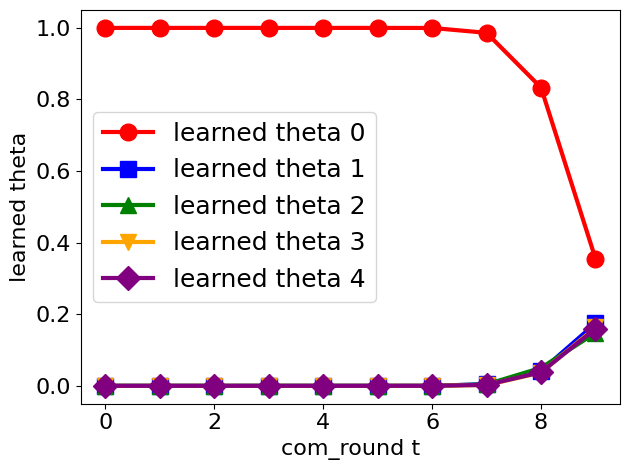

In [ ]:
#%%
#%% this is for sgd optmizer to train unfolding
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#Data loading step and settings
#%% Parameters
T = 10                  # number of rounds for FL
M = 100                 # number of learning iterations
Es = [2, 1, 1, 1, 1]    # number of epochs
batch_size = 50         # mini-batch size
lr_du = 0.001           # learning rate for proposed preprocess
mu = 0.01               # learning rate for ClientUpdate
num_feature = 128       # dimension of hidden layers
#q = 1                   # parameter for DR-FedAvg

# Fixed parameters
K = 5                   # number of clients
datalocation = '/content/drive/MyDrive/Colab Notebooks/mnist/5clients_env3_4/'                     # data for env3
N = sum([1713, 1713, 1713, 1713, 1716])                     # number of all training data for env3

print("Set parameters", flush=True)

#%% Global Data Load
root = '.'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=download)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print("Download done", flush=True)

#%% Local Data setting
datasizes_test = []
for i in range(K):
    datasizes_test.append(int(round(len(test_set)/K)))
test_sets = torch.utils.data.random_split(dataset=test_set, lengths=datasizes_test, generator=torch.Generator().manual_seed(42))

test_loaders = []
train_datasets = []

for node in range (K):
    localtraindata = np.load(datalocation+'train/'+str(node)+'.npz', allow_pickle=True)     # training data load
    localtraindata = np.atleast_1d(localtraindata['data'])
    inputs = localtraindata[0]['x']
    targets = localtraindata[0]['y']
    tensor_X = torch.stack([torch.from_numpy(i) for i in inputs])
    tensor_y = torch.stack([torch.from_numpy(np.array(i)) for i in targets])
    train_datasets.append(torch.utils.data.TensorDataset(tensor_X,tensor_y))
    test_loaders.append(torch.utils.data.DataLoader(dataset=test_sets[node], batch_size=batch_size, shuffle=False))
pk = [len(train_datasets[node])/N for node in range(K)]

print("Set local data", flush=True)

#%% Definition of Initial Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, num_feature)
        self.l2 = nn.Linear(num_feature, num_feature)
        self.l3 = nn.Linear(num_feature, 10)
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return F.log_softmax(x, dim=1)

#%% Definition of Unfolded FL
class TrainDUW(nn.Module):
    def __init__(self) -> None:
        super(TrainDUW, self).__init__()
        self.thetak = nn.ParameterList([nn.Parameter(torch.ones(T)*np.sqrt(len(train_datasets[i])/N)) for i in range(K)])
        # initial value: N_k/N
    def network(self, W1, b1, W2, b2, W3, b3, x):
        x = torch.relu(torch.matmul(x,W1.T)+b1.T)
        x = torch.relu(torch.matmul(x,W2.T)+b2.T)
        x = F.log_softmax(torch.matmul(x,W3.T)+b3.T, dim=1)
        return x
    def forward(self, aveW1, aveb1, aveW2, aveb2, aveW3, aveb3):
        outputlists = []
        targetlists = []
        for itr in range(T+1):
            tmploss = 0.
            outputlist = []
            targetlist = []
            if not itr == T:
                sumweights = sum([self.thetak[x][itr]**2 for x in range(K)])
            for node in range(K):
                weight1, bias1, weight2, bias2, weight3, bias3 = aveW1, aveb1, aveW2, aveb2, aveW3, aveb3
                weight1.requires_grad_(True)
                bias1.requires_grad_(True)
                weight2.requires_grad_(True)
                bias2.requires_grad_(True)
                weight3.requires_grad_(True)
                bias3.requires_grad_(True)
                train_loader_node = torch.utils.data.DataLoader(dataset=train_datasets[node], batch_size=batch_size, shuffle=True)
                outputvalues = []
                targetvalues = []
                for ep in range(Es[node]):
                    for (input, target) in train_loader_node:
                        input = input.view(-1, 28*28)
                        output = self.network(weight1,bias1,weight2,bias2,weight3,bias3,input)
                        outputvalues.append(output)
                        targetvalues.append(target)
                        if not itr == T:
                            loss = F.nll_loss(output, target)
                            tmploss += loss.item()
                            w1grad = torch.autograd.grad(loss,weight1,retain_graph=True)
                            b1grad = torch.autograd.grad(loss,bias1,retain_graph=True)
                            w2grad = torch.autograd.grad(loss,weight2,retain_graph=True)
                            b2grad = torch.autograd.grad(loss,bias2,retain_graph=True)
                            w3grad = torch.autograd.grad(loss,weight3,retain_graph=True)
                            b3grad = torch.autograd.grad(loss,bias3,retain_graph=True)
                            weight1 = weight1 - mu * w1grad[0].detach()
                            bias1 = bias1 - mu * b1grad[0].detach()
                            weight2 = weight2 - mu * w2grad[0].detach()
                            bias2 = bias2 - mu * b2grad[0].detach()
                            weight3 = weight3 - mu * w3grad[0].detach()
                            bias3 = bias3 - mu * b3grad[0].detach()
                if not itr == T:
                    if node == 0:
                        weight0 = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = weight1*weight0, bias1*weight0, weight2*weight0, bias2*weight0, weight3*weight0, bias3*weight0
                    else:
                        weightnode = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = W1 + weight1*weightnode, b1 + bias1*weightnode, W2 + weight2*weightnode, b2 + bias2*weightnode, W3 + weight3*weightnode, b3 + bias3*weightnode
                outputlist.append(outputvalues)
                targetlist.append(targetvalues)
                if itr == T:
                    print(self.thetak[node]**2/sumweights, flush=True)
            aveW1, aveb1, aveW2, aveb2, aveW3, aveb3 = W1, b1, W2, b2, W3, b3
            outputlists.append(outputlist)
            targetlists.append(targetlist)
        return outputlists, targetlists

print("Network defined", flush=True)


#%% Functions
def model_initialize(initmodel):
    models = []
    for i in range(K):
        models.append(Net())
    for node in range(K):
        models[node].l1.weight.data = initmodel.l1.weight.data.clone()
        models[node].l1.bias.data = initmodel.l1.bias.data.clone()
        models[node].l2.weight.data = initmodel.l2.weight.data.clone()
        models[node].l2.bias.data = initmodel.l2.bias.data.clone()
        models[node].l3.weight.data = initmodel.l3.weight.data.clone()
        models[node].l3.bias.data = initmodel.l3.bias.data.clone()
    return models

#%% Model Sharing
model = Net()       # common initial model
models = model_initialize(model)        # models for proposed DUN

# initial model parameters
aveW1 = model.l1.weight.data.clone().requires_grad_(False)
aveb1 = model.l1.bias.data.clone().requires_grad_(False)
aveW2 = model.l2.weight.data.clone().requires_grad_(False)
aveb2 = model.l2.bias.data.clone().requires_grad_(False)
aveW3 = model.l3.weight.data.clone().requires_grad_(False)
aveb3 = model.l3.bias.data.clone().requires_grad_(False)

print("Model sharing done", flush=True)


#%%
import time

# Start the timer
start_time = time.time()
modelDUR = TrainDUW()
learnedweightsR = torch.zeros(M+1, T, K)
sumweightsR = torch.zeros(T)
for itr in range(T):
    sumweightsR[itr] = sum([modelDUR.thetak[x][itr].item()**2 for x in range(K)])
for node in range(K):
    learnedweightsR[0,:,node] = modelDUR.thetak[node].detach()**2 / sumweightsR
#optimizerDUR = optim.Adam(modelDUR.parameters(), lr=lr_du)
optimizerDUR = optim.SGD(modelDUR.parameters(), lr=lr_du, weight_decay=0.001)

#%%,weight_decay=0.01
# Training of Deep Unfolding-based Weights
outerloss = []
i = 0
for loop in range(M):
    i = i+1
    print(i, flush=True)
    optimizerDUR.zero_grad()
    outputlists, targetlists = modelDUR(aveW1, aveb1, aveW2, aveb2, aveW3, aveb3)
    loss = 0
    for j in range(T+1):
        for node in range(K):
            num_localdata = len(outputlists[j][node])
            for l in range(num_localdata):
                loss += F.nll_loss(outputlists[j][node][l], targetlists[j][node][l])
    loss.backward()
    optimizerDUR.step()
    outerloss.append(loss.item())
    sumweightsR = torch.zeros(T)
    for itr in range(T):
        sumweightsR[itr] = sum([modelDUR.thetak[x][itr].item()**2 for x in range(K)])
    for node in range(K):
        learnedweightsR[i,:,node] = modelDUR.thetak[node].detach()**2 / sumweightsR
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print("Execution time:", elapsed_time, "seconds")
print("Deep unfolding done", flush=True)
# print ('outerloss = ', outerloss, flush=True)


#Plot weights for each client in each round
import matplotlib.pyplot as plt
import numpy as np
import csv as csv
# Learned thetak Save
results = []
for node in range(K):
    labelname = 'learned theta ' + str(node)
    data = [i for i in learnedweightsR[M, :, node]]
    results.append([labelname] + data)

# Save results to a CSV file
filename = "learned_thetakREnv2_propose.csv"
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
    writer.writerows(results)  # Write data rows

print(f"Results saved to {filename}")


#Plot this same as other figure.
import matplotlib.pyplot as plt
import numpy as np

K = 5
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Specify the desired colors for each line
markers = ['o', 's', '^', 'v', 'D']  # Specify the desired markers for each line

# Learned thetak
fig2 = plt.figure()
for node in range(K):
    labelname = 'learned theta ' + str(node)
    plt.plot([i for i in learnedweightsR[M, :, node]], label=labelname, linewidth=3, marker=markers[node], markersize=12, color=colors[node])
plt.legend(fontsize=18)
plt.xlabel("com_round t", fontsize=16)
plt.ylabel("learned theta", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
fig2.savefig("learned_thetak.png")


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Training settings
num_rounds = 2
learning_rate = 0.01  # Adjust as needed

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []
global_parameters=[]
global_cost=[]

# Array to store global cost
GlobalCostperRoundAll=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values
client_weights=learnedweightsR[node][-1]



In [ ]:
client_weights

tensor([0.2311, 0.1900, 0.1926, 0.1974, 0.1889])

In [ ]:
#normalized weights
# Get the weights for the specified node
client_weights = learnedweightsR[node][-1]

# Normalize the weights
normalized_weights = client_weights / torch.sum(client_weights)

# Print the normalized weights
print("Original Weights:", client_weights)
print("Normalized Weights:", normalized_weights)

#But i appears the weights are already normalized.

In [ ]:
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]

    #Initialize aggregated parameters to global result of previous round

    # Train each client's data on their VQC models
    i=0
    i_max=num_clients
    for client_id, data in client_data.items():
       if i!=i_max+1:
        print(client_id)
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization

        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        print(len(Locallog.parameters[-1])) #12 parameters for each client
        print(client_weights[i])

        #Normalize these weights


        import tensorflow as tf
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        # Convert the NumPy array to a TensorFlow tensor
        parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        print(aggregated_params)
        i=i+1

    global_parameters=aggregated_params/num_clients
    print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    #global_parameters=global_optimizer_log.parameters[-1]
#print(global_parameters)
# Aggregate client parameters

global_cost = global_optimizer_log.costs
print(f"Round {round_num},global cost: {global_cost}")




Client_1
12
tensor(0.2311)
Round 0, Client Client_1: parameters = [ 1.24471211  0.80986965 -0.13672046  2.23398156  1.15150835  0.59769356
  0.30889673 -1.35729337  1.7092923   2.07911413  0.74184855 -0.22112992]
Round 0, Client Client_1: parameters = [ 0.28765348  0.1871612  -0.03159615  0.5162741   0.26611406  0.13812722
  0.07138616 -0.31367105  0.39501816  0.48048416  0.1714415  -0.05110322]
tf.Tensor(
[ 0.28765348  0.1871612  -0.03159615  0.5162741   0.26611406  0.13812722
  0.07138616 -0.31367105  0.39501816  0.48048416  0.1714415  -0.05110322], shape=(12,), dtype=float32)
Client_2
12
tensor(0.1900)
Round 0, Client Client_2: parameters = [-1.43233272 -0.5153538   1.16445717  2.125891    0.84265297  0.82344027
  1.23535959  1.63045426  2.05493346 -0.51867127  0.73237582  0.77277028]
Round 0, Client Client_2: parameters = [-0.27211845 -0.09790831  0.22122674  0.40388253  0.1600895   0.15643941
  0.23469695  0.30975813  0.39040184 -0.09853858  0.13913874  0.14681299]
tf.Tensor(
[ 0.

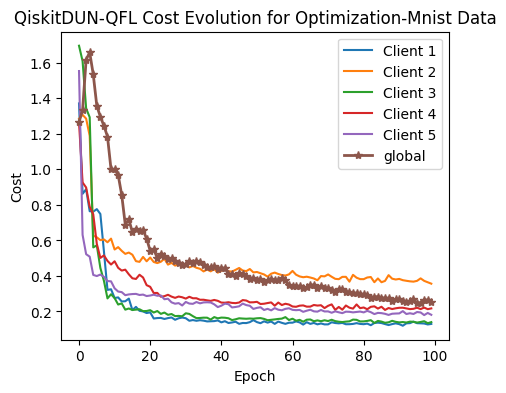

In [ ]:
        #each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs[-100:], label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitDUN-QFL Cost Evolution for Optimization-Mnist Data')
plt.legend()
plt.show()


In [ ]:


        #client_parameters.append(Locallog.parameters[-1]*client_weights[client_id])
        cost = Locallog.costs[-1]
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        weighted_aggregated_params_perclient=np.sum(aggregated_params, axis=0) * client_weights[client_id]
        # Add the client's latest parameters to the aggregated_params

    # Weighted aggregation step
    #weighted_aggregated_params = np.sum(aggregated_params, axis=0) / np.sum(client_weights)
print("Local training done")

# Update global parameters for the next round
global_parameters = aggregated_params
     # Aggregate client parameters
print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")

     # Update the global optimizer log with the aggregated parameters
global_optimizer_log.parameters.append(global_parameters)
global_model.fit(train_data, train_labels)
global_cost = global_optimizer_log.costs
print(f"Round {round_num},global cost: {global_cost}")

ValueError: ignored

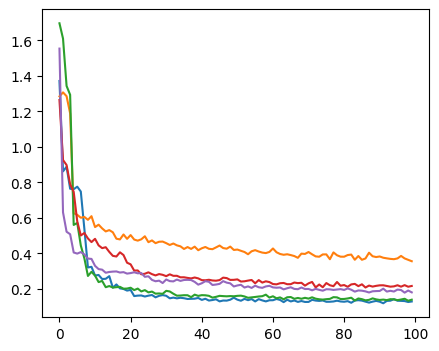

In [ ]:
#each client cost variations over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs[-100], label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution for Optimization-Mnist Data with DUN')
plt.legend()
plt.show()

Measure the Classification Accuracy

In [ ]:
result = vqc.run(quantum_instance)

print("testing accuracy: {}".format(result['testing_accuracy']))
print("prediction of datapoints:")
print("Actual: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))